In [1]:
import tensorflow as tf

In [2]:
import pandas as pd
import os
import numpy as np
from sklearn.utils import class_weight
from keras_preprocessing import image as im
tf.random.set_seed(
    5
)

# Loading data

In [3]:
def load_data(image_path, annotations_path):
    df = pd.read_csv(annotations_path)
    df = df[~df['human_sentiment'].isna()]
    in_folder = os.listdir(image_path)
    df.loc[df['image_name'].isin(in_folder), 'image_name'] = \
    df.loc[df['image_name'].isin(in_folder), 'image_name'].apply(lambda x: os.path.join(image_path,x))
    images = []
    for image_name in df['image_name'].values:
        images.append(np.array(im.load_img(image_name, target_size=(224,224))))
    images = np.array(images)
    images = images/255
    annotations = df['annotation'].str.lower().values
    return images, annotations

In [4]:
images, annotations = load_data("../../../../images/", '../../../../emo-at-cap.csv')

# Processing of data

In [5]:
import nltk

In [6]:
tokenizer = nltk.tokenize.WordPunctTokenizer()

In [7]:
tokenized = [tokenizer.tokenize(i) for i in annotations]

In [8]:
unique_tokens, unique_counts = np.unique(np.hstack(tokenized), return_counts=True)

In [9]:
class_weights = class_weight.compute_class_weight('balanced', np.unique(np.hstack(tokenized)), np.hstack(tokenized))

/home/ec2-user/anaconda3/envs/amazonei_tensorflow2_p36/lib/python3.6/site-packages/sklearn/utils/validation.py:72: FutureWarning: Pass classes=["'" ',' '-' ... 'youth' 'исходный' 'текст'], y=['the' 'man' 'is' ... 'with' 'some' 'clothes'] as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  "will result in an error", FutureWarning)


In [10]:
frequency = sorted(list(zip(unique_tokens, unique_counts)), key = lambda x: x[1])[::-1][:50]

In [11]:
frequency

[('the', 3261),
 ('is', 2031),
 ('man', 1905),
 ('and', 1536),
 ('woman', 1361),
 ('are', 1036),
 ('a', 963),
 ('to', 891),
 ('looks', 751),
 ('happy', 705),
 ('with', 547),
 ('something', 480),
 ('men', 478),
 ('of', 463),
 ('two', 408),
 ('other', 361),
 ('people', 343),
 ('couple', 334),
 (',', 330),
 ('in', 278),
 ('look', 270),
 ('because', 265),
 ('they', 256),
 ('about', 247),
 ('on', 246),
 ('at', 192),
 ('trying', 190),
 ('serious', 189),
 ('women', 184),
 ('each', 179),
 ('together', 176),
 ('by', 175),
 ('having', 171),
 ('flirting', 165),
 ('he', 155),
 ('smiling', 151),
 ('arguing', 141),
 ('angry', 140),
 ('scared', 138),
 ('worried', 137),
 ('hugging', 135),
 ('surprised', 134),
 ('calm', 133),
 ('company', 131),
 ('her', 129),
 ('group', 123),
 ('for', 121),
 ('she', 117),
 ('looking', 117),
 ('his', 115)]

In [12]:
len(unique_tokens)

2162

In [13]:
pad_token = '<PAD>'
start_token = '<S>'
end_token = '<E>'

In [14]:
vocab = dict(zip(unique_tokens,list(range(3,len(unique_tokens)+3))))
vocab[pad_token] = 0
vocab[start_token] = 1
vocab[end_token] = 2

In [15]:
inverse_vocab = dict([(v,k) for k,v in vocab.items()])

In [16]:
def padd(sentences, pad_token, start_token, end_token, maxlen=10):
    padded_sentences = []
    for i in sentences:
        sentence = [start_token] + i + [end_token]
        if len(sentence)>=maxlen+2:
            sentence = sentence[:maxlen+2]
        else:
            sentence = sentence+[pad_token for i in range(maxlen+2-len(sentence))]
        padded_sentences.append(sentence)
    return padded_sentences

In [17]:
padded_sentences = padd(tokenized, pad_token, start_token, end_token, maxlen=10)

In [18]:
np.mean([len(i) for i in padded_sentences])

12.0

In [19]:
indexed = list(map(lambda x: [vocab[i] for i in x],padded_sentences))

In [20]:
images.shape

(3840, 224, 224, 3)

In [21]:
len(class_weights)

2162

In [22]:
class_weights = list(class_weights)
class_weights.insert(0, 1)
class_weights.insert(1, 1)
class_weights.insert(2, 1)

In [23]:
len(class_weights), len(vocab)

(2165, 2165)

In [24]:
class_weights[:4]

[1, 1, 1, 0.21013259327782918]

In [25]:
class_weights = np.array(class_weights)

In [26]:
class_weights.shape

(2165,)

# Model with transfer learning

In [27]:
def calc_size(x, f, s, padding='same'):
    p = 2 if padding=='same' else 1
    return (x-f+2)/s+1

### Convolutional model

In [28]:
import tensorflow.keras.applications as apps


In [29]:
class ConvEncoder(tf.keras.Model):
    def __init__(self):
        super(ConvEncoder, self).__init__()
        #building resnet
        self.resnet_extractor = apps.ResNet152V2(include_top=False, weights='imagenet')
        self.resnet_extractor.trainable = False
        self.pooling = tf.keras.layers.GlobalAveragePooling2D()
        self.dense1 = tf.keras.layers.Dense(units=256, activation='relu')

    def call(self, input):
        extracted = self.pooling(self.resnet_extractor(input))
        return self.dense1(extracted)

In [30]:
conv_encoder = ConvEncoder()

In [31]:
conv_res = conv_encoder(np.expand_dims(images[0],axis=0))


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.



In [32]:
conv_res

<tf.Tensor: shape=(1, 256), dtype=float32, numpy=
array([[0.        , 0.45110387, 0.        , 0.8999197 , 0.04021239,
        1.0338805 , 0.        , 1.2185142 , 0.        , 0.78247416,
        0.17089391, 0.        , 0.395425  , 0.16711998, 0.15840748,
        1.2803931 , 0.        , 0.        , 1.1242403 , 0.66152096,
        0.17552578, 0.54913604, 0.3783183 , 0.91132635, 0.        ,
        0.        , 0.911293  , 0.        , 0.        , 0.48045883,
        0.92532384, 0.38483918, 0.55450535, 0.        , 0.        ,
        0.64365196, 0.4652435 , 0.        , 0.88236743, 0.1019963 ,
        0.14806342, 0.5517235 , 0.        , 0.5829716 , 0.        ,
        0.        , 1.2746992 , 0.        , 1.9214394 , 0.70789796,
        0.        , 0.84508026, 0.7652738 , 0.        , 0.        ,
        0.5421097 , 0.5754764 , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.16309988, 0.        , 1.6102335 ,
        0.        , 0.        , 2.0704203 , 0.8703097 , 0.        

### LSTM model

### making w2v embeddings

In [33]:
!pip install gensim

     |████████████████████████████████| 23.9 MB 28.9 MB/s eta 0:00:01
     |████████████████████████████████| 57 kB 7.7 MB/s  eta 0:00:01
You should consider upgrading via the '/home/ec2-user/anaconda3/envs/amazonei_tensorflow2_p36/bin/python -m pip install --upgrade pip' command.


In [34]:
import gensim.downloader as api

/home/ec2-user/anaconda3/envs/amazonei_tensorflow2_p36/lib/python3.6/site-packages/gensim/similarities/__init__.py:15: UserWarning: The gensim.similarities.levenshtein submodule is disabled, because the optional Levenshtein package <https://pypi.org/project/python-Levenshtein/> is unavailable. Install Levenhstein (e.g. `pip install python-Levenshtein`) to suppress this warning.
  warnings.warn(msg)


In [35]:
w2v_embeddings = api.load('word2vec-google-news-300')

[==================================================] 100.0% 1662.8/1662.8MB downloaded


In [36]:
def build_embeddings(vocab, word_vectors, embed_dim):
    emb_matrix = np.zeros(shape=(len(vocab)+ 1 , embed_dim), dtype='float32')
    count = 0
    for word, i in vocab.items():
        try:
            emb_matrix[i, :] = word_vectors.get_vector(word)
        except:
            count += 1
            emb_matrix[i, :] = np.random.uniform(-0.1, 0.1, embed_dim)
    print('{} words are out of vocabulary：'.format(count))
    return emb_matrix


In [37]:
w2v_embeddings = build_embeddings(vocab, w2v_embeddings, 300)

22 words are out of vocabulary：


### attention

In [38]:
class BahdanauAttention(tf.keras.Model):
  def __init__(self, units):
    super(BahdanauAttention, self).__init__()
    self.W1 = tf.keras.layers.Dense(units)
    self.W2 = tf.keras.layers.Dense(units)
    self.V = tf.keras.layers.Dense(1)

  def call(self, features, hidden):
    # features(CNN_encoder output) shape == (batch_size, 64, embedding_dim)

    # hidden shape == (batch_size, hidden_size)
    # hidden_with_time_axis shape == (batch_size, 1, hidden_size)
    hidden_with_time_axis = tf.expand_dims(hidden, 1)

    # attention_hidden_layer shape == (batch_size, 64, units)
    attention_hidden_layer = (tf.nn.tanh(self.W1(features) +
                                         self.W2(hidden_with_time_axis)))

    # score shape == (batch_size, 64, 1)
    # This gives you an unnormalized score for each image feature.
    score = self.V(attention_hidden_layer)

    # attention_weights shape == (batch_size, 64, 1)
    attention_weights = tf.nn.softmax(score, axis=1)

    # context_vector shape after sum == (batch_size, hidden_size)
    context_vector = attention_weights * features
    context_vector = tf.reduce_sum(context_vector, axis=1)

    return context_vector, attention_weights

### building model

In [39]:
class LSTMDecoder(tf.keras.Model):
    def __init__(self, max_tokens, units=512, embeddings=None, dim=128):
        super(LSTMDecoder, self).__init__()
        self.units = units
        self.embeddings = tf.keras.layers.Embedding(input_dim=max_tokens+1, output_dim=dim, name='embeddings',
                                                   weights=[embeddings])
        self.dropout = tf.keras.layers.SpatialDropout1D(0.2)
        self.lstm = tf.keras.layers.LSTM(units=self.units, return_state=True, return_sequences=True, name='lstm_decoder', 
                                         recurrent_dropout=0.1,recurrent_initializer='glorot_uniform')
        self.intermidiate_dense = tf.keras.layers.Dense(units=self.units, activation='relu')
        self.output_dense = tf.keras.layers.Dense(units=max_tokens)
        self.attention = BahdanauAttention(self.units)

    def call(self, input, features, hidden):
        embedded = self.dropout(self.embeddings(input))
        context_vector, attention_weights = self.attention(features, hidden)
        concated = tf.concat([tf.expand_dims(context_vector, 1), embedded], axis=-1)
        result_lstm, state_h, state_c = self.lstm(concated)
        intermidiate_dense = self.intermidiate_dense(result_lstm)
        intermidiate_dense = tf.reshape(intermidiate_dense, (-1, intermidiate_dense.shape[2]))
        logits = self.output_dense(intermidiate_dense)
        return logits, state_h, attention_weights
    
    def reset_state(self, batch_size):
        return tf.zeros((batch_size, self.units))

In [40]:
lstm_decoder = LSTMDecoder(len(inverse_vocab), 256, w2v_embeddings, dim=300)

### Training

In [41]:
from sklearn.model_selection import train_test_split

In [42]:
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(reduction='none',
                                                                         from_logits=True)
lr_value = 1e-4
reduction_power = 10
optimizer = tf.keras.optimizers.RMSprop(learning_rate=lr_value)
with_weights = False

In [43]:
epochs = 30
batch_size = 64
patience_epochs = 2

In [44]:
def loss_function(real, pred, loss_weights):
        mask = tf.math.logical_not(tf.math.equal(real, vocab[pad_token]))
        loss_ = loss_object(real, pred)
        mask = tf.cast(mask, dtype=loss_.dtype)
        loss_ *= mask
        loss_weights = tf.cast(loss_weights, dtype=loss_.dtype)
        loss_*=loss_weights
        return loss_

In [45]:
@tf.function
def train_step(image, target, lengths, optimizer):
    hidden = lstm_decoder.reset_state(batch_size=target.shape[0])

    with tf.GradientTape() as tape:
        features = conv_encoder(image)
        # Teacher forcing - feeding the target as the next input
        batched_loss = []
        for t in range(1, target.shape[1]):
            
            dec_input = tf.expand_dims(target[:, t-1], 1)
            result, hidden, _ = lstm_decoder(dec_input, features, hidden)
            weights = tf.broadcast_to(class_weights, shape=(target[:,t].shape[0], class_weights.shape[0]))
            weights = tf.gather(weights, target[:,t],axis=1, batch_dims=1)
            batched_loss.append(loss_function(target[:, t], result, weights))
        batched_loss = tf.reshape(tf.stack(batched_loss), shape=target[:,1:].shape)
        batched_loss = tf.reduce_sum(batched_loss, axis=1)
        lengths = tf.cast(lengths, dtype=batched_loss.dtype)
        loss = tf.reduce_mean(batched_loss / lengths)

    perplexity = tf.exp(loss)

    variables = conv_encoder.trainable_variables + lstm_decoder.trainable_variables
    gradients = tape.gradient(loss, variables)

    optimizer.apply_gradients(zip(gradients, variables))

    return loss, perplexity

In [46]:
@tf.function
def evaluate(image, target, lengths, optimizer):
    hidden = lstm_decoder.reset_state(batch_size=target.shape[0])

    features = conv_encoder(image)
    # Teacher forcing - feeding the target as the next input
    batched_loss = []
    for t in range(1, target.shape[1]):

        dec_input = tf.expand_dims(target[:, t-1], 1)
        result, hidden, _ = lstm_decoder(dec_input, features, hidden)
        weights = tf.broadcast_to(class_weights, shape=(target[:,t].shape[0], class_weights.shape[0]))
        weights = tf.gather(weights, target[:,t],axis=1, batch_dims=1)
        batched_loss.append(loss_function(target[:, t], result, weights))
    
    batched_loss = tf.reshape(tf.stack(batched_loss), shape=target[:,1:].shape)
    batched_loss = tf.reduce_sum(batched_loss, axis=1)
    lengths = tf.cast(lengths, dtype=batched_loss.dtype)
    loss = tf.reduce_mean(batched_loss / lengths)
    perplexity = tf.exp(loss)


    return loss, perplexity

In [47]:
train_images, val_images, train_sequences, val_sequences =  train_test_split(images, indexed, test_size=0.2, random_state=10)
val_images, test_images, val_sequences, test_sequences =  train_test_split(val_images, val_sequences, test_size=0.5, random_state=10)

In [48]:
train_length = (np.array(train_sequences)!=vocab[pad_token]).sum(axis=1)-2

In [49]:
val_length = (np.array(val_sequences)!=vocab[pad_token]).sum(axis=1)-2

In [50]:
test_length = (np.array(test_sequences)!=vocab[pad_token]).sum(axis=1)-2

In [51]:
train_images = np.array(np.array_split(train_images, len(train_images)//batch_size))
test_images = np.array(np.array_split(test_images, len(test_images)//batch_size))
val_images = np.array(np.array_split(val_images, len(val_images)//batch_size))

train_sequences = np.array(np.array_split(train_sequences, len(train_sequences)//batch_size))
test_sequences = np.array(np.array_split(test_sequences, len(test_sequences)//batch_size))
val_sequences = np.array(np.array_split(val_sequences, len(val_sequences)//batch_size))

train_length = np.array(np.array_split(train_length, len(train_length)//batch_size))
test_length = np.array(np.array_split(test_length, len(test_length)//batch_size))
val_length = np.array(np.array_split(val_length, len(val_length)//batch_size))


In [52]:
train_images.shape, train_sequences.shape, train_length.shape

((48, 64, 224, 224, 3), (48, 64, 12), (48, 64))

In [53]:
!pip install tqdm

     |████████████████████████████████| 76 kB 6.1 MB/s  eta 0:00:01
You should consider upgrading via the '/home/ec2-user/anaconda3/envs/amazonei_tensorflow2_p36/bin/python -m pip install --upgrade pip' command.


In [54]:
if not with_weights:
    class_weights = np.array([1 for i in range(len(class_weights))])

In [55]:
from tqdm import tqdm

In [56]:
train_loss = []
train_perplexity = []
val_loss = []
val_perplexity = []
overfit_epochs = 0
for epoch in range(epochs):
    epoch_train_loss = 0
    epoch_train_perplexity = 0
    epoch_val_loss = 0
    epoch_val_perplexity = 0
    for batch_train_images, batch_train_sequences, batched_train_length in tqdm(zip(train_images,train_sequences,train_length)):
        batched_train_loss, batched_train_perplexity = train_step(batch_train_images,batch_train_sequences,batched_train_length, optimizer)
        epoch_train_loss+=batched_train_loss
        epoch_train_perplexity+=batched_train_perplexity
    epoch_train_loss = epoch_train_loss/train_images.shape[0]
    epoch_train_perplexity = epoch_train_perplexity/train_images.shape[0]
    train_loss.append(epoch_train_loss)
    train_perplexity.append(epoch_train_perplexity)
    print('Finished epoch {}; Train loss : {}; Train perplexity : {}'.format(epoch,epoch_train_loss,epoch_train_perplexity))
    for batch_val_images, batch_val_sequences, batched_val_length in zip(val_images,val_sequences,val_length):
        batched_val_loss, batched_val_perplexity = evaluate(batch_val_images, batch_val_sequences, batched_val_length, optimizer)
        epoch_val_loss+=batched_val_loss
        epoch_val_perplexity+=batched_val_perplexity
    epoch_val_loss = epoch_val_loss/val_images.shape[0]
    epoch_val_perplexity = epoch_val_perplexity/val_images.shape[0]
    val_perplexity.append(epoch_val_perplexity)
    val_loss.append(epoch_val_loss)
    print('Validation loss : {}; Validation perplexity : {}'.format(epoch_val_loss,epoch_val_perplexity))
    if len(val_loss)>=2 and val_loss[-2]<val_loss[-1]:
        overfit_epochs+=1
    else:
        overfit_epochs=0
    if overfit_epochs==patience_epochs:
        lr_value/=reduction_power
        optimizer.lr.assign(lr_value)
        print('There was no improvement in validation loss for {} epochs, thus reducing learning rate'.format(patience_epochs))

48it [01:20,  1.67s/it]


Finished epoch 0; Train loss : 7.713783264160156; Train perplexity : 3322.46875
Validation loss : 6.209583282470703; Validation perplexity : 504.005859375


48it [00:48,  1.02s/it]


Finished epoch 1; Train loss : 5.830974578857422; Train perplexity : 345.0384826660156
Validation loss : 5.736627578735352; Validation perplexity : 313.3835144042969


48it [00:49,  1.03s/it]


Finished epoch 2; Train loss : 5.669843673706055; Train perplexity : 292.6361389160156
Validation loss : 5.7072014808654785; Validation perplexity : 304.5351867675781


48it [00:49,  1.03s/it]


Finished epoch 3; Train loss : 5.580689907073975; Train perplexity : 267.7345886230469
Validation loss : 5.612168788909912; Validation perplexity : 277.49444580078125


48it [00:49,  1.04s/it]


Finished epoch 4; Train loss : 5.423477649688721; Train perplexity : 228.99102783203125
Validation loss : 5.496044635772705; Validation perplexity : 247.6101531982422


48it [00:48,  1.02s/it]


Finished epoch 5; Train loss : 5.265373229980469; Train perplexity : 195.6326141357422
Validation loss : 5.360291004180908; Validation perplexity : 216.38148498535156


48it [00:49,  1.02s/it]


Finished epoch 6; Train loss : 5.112905025482178; Train perplexity : 168.0128173828125
Validation loss : 5.241258144378662; Validation perplexity : 192.48951721191406


48it [00:48,  1.02s/it]


Finished epoch 7; Train loss : 4.975520610809326; Train perplexity : 146.56407165527344
Validation loss : 5.142752170562744; Validation perplexity : 174.8878631591797


48it [00:49,  1.03s/it]


Finished epoch 8; Train loss : 4.835031509399414; Train perplexity : 127.30863189697266
Validation loss : 5.05100154876709; Validation perplexity : 161.06826782226562


48it [00:49,  1.02s/it]


Finished epoch 9; Train loss : 4.707993030548096; Train perplexity : 112.36226654052734
Validation loss : 4.901970863342285; Validation perplexity : 138.24693298339844


48it [00:49,  1.02s/it]


Finished epoch 10; Train loss : 4.590696811676025; Train perplexity : 100.5475082397461
Validation loss : 4.828010082244873; Validation perplexity : 129.3452606201172


48it [00:49,  1.04s/it]


Finished epoch 11; Train loss : 4.461187839508057; Train perplexity : 87.84061431884766
Validation loss : 4.706614971160889; Validation perplexity : 113.95654296875


48it [00:50,  1.05s/it]


Finished epoch 12; Train loss : 4.350745677947998; Train perplexity : 78.51351165771484
Validation loss : 4.658327579498291; Validation perplexity : 109.46517944335938


48it [00:49,  1.02s/it]


Finished epoch 13; Train loss : 4.263441562652588; Train perplexity : 72.23896026611328
Validation loss : 4.538976192474365; Validation perplexity : 96.22555541992188


48it [00:49,  1.04s/it]


Finished epoch 14; Train loss : 4.167473316192627; Train perplexity : 65.46126556396484
Validation loss : 4.478452682495117; Validation perplexity : 90.0842514038086


48it [00:50,  1.05s/it]


Finished epoch 15; Train loss : 4.086548805236816; Train perplexity : 60.47304153442383
Validation loss : 4.411447048187256; Validation perplexity : 84.52164459228516


48it [00:52,  1.10s/it]


Finished epoch 16; Train loss : 4.020841121673584; Train perplexity : 56.51936340332031
Validation loss : 4.609804630279541; Validation perplexity : 101.61648559570312


48it [00:56,  1.18s/it]


Finished epoch 17; Train loss : 3.96109938621521; Train perplexity : 53.29623031616211
Validation loss : 4.3196330070495605; Validation perplexity : 77.08638763427734


48it [01:03,  1.32s/it]


Finished epoch 18; Train loss : 3.898318290710449; Train perplexity : 49.98745346069336
Validation loss : 4.330982208251953; Validation perplexity : 79.02396392822266


48it [00:49,  1.02s/it]


Finished epoch 19; Train loss : 3.8571622371673584; Train perplexity : 48.02592468261719
Validation loss : 4.253018856048584; Validation perplexity : 72.05107116699219


48it [00:49,  1.04s/it]


Finished epoch 20; Train loss : 3.79934024810791; Train perplexity : 45.40969467163086
Validation loss : 4.209603786468506; Validation perplexity : 69.36430358886719


48it [00:48,  1.02s/it]


Finished epoch 21; Train loss : 3.771559476852417; Train perplexity : 44.2363395690918
Validation loss : 4.193394184112549; Validation perplexity : 68.35504913330078


48it [00:49,  1.02s/it]


Finished epoch 22; Train loss : 3.720245599746704; Train perplexity : 41.77998733520508
Validation loss : 4.164291858673096; Validation perplexity : 66.54451751708984


48it [00:48,  1.01s/it]


Finished epoch 23; Train loss : 3.6749942302703857; Train perplexity : 39.974449157714844
Validation loss : 4.233492374420166; Validation perplexity : 70.2017593383789


48it [00:49,  1.03s/it]


Finished epoch 24; Train loss : 3.6444005966186523; Train perplexity : 38.750762939453125
Validation loss : 4.157243728637695; Validation perplexity : 66.5087890625


48it [00:49,  1.02s/it]


Finished epoch 25; Train loss : 3.600078582763672; Train perplexity : 37.084598541259766
Validation loss : 4.099969387054443; Validation perplexity : 62.27548599243164


48it [00:49,  1.04s/it]


Finished epoch 26; Train loss : 3.5745561122894287; Train perplexity : 36.10860061645508
Validation loss : 4.085587978363037; Validation perplexity : 61.852054595947266


48it [00:49,  1.04s/it]


Finished epoch 27; Train loss : 3.53759503364563; Train perplexity : 34.811180114746094
Validation loss : 4.044961452484131; Validation perplexity : 58.57761001586914


48it [00:50,  1.05s/it]


Finished epoch 28; Train loss : 3.507171392440796; Train perplexity : 33.77035903930664
Validation loss : 4.048913478851318; Validation perplexity : 59.315155029296875


48it [00:49,  1.02s/it]


Finished epoch 29; Train loss : 3.4855706691741943; Train perplexity : 33.08759689331055
Validation loss : 4.0069050788879395; Validation perplexity : 56.714202880859375


# Viewing and saving results

In [57]:
df = pd.DataFrame()
model_name = 'conv_lstm_logits_transfer_learning_w2v_fixed_size_attention'
df['train_perplexity'] = [i.numpy() for i in train_perplexity]
df['val_perplexity'] = [i.numpy() for i in val_perplexity]
df['train_loss'] = [i.numpy() for i in train_loss]
df['val_loss'] = [i.numpy() for i in val_loss]


In [58]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

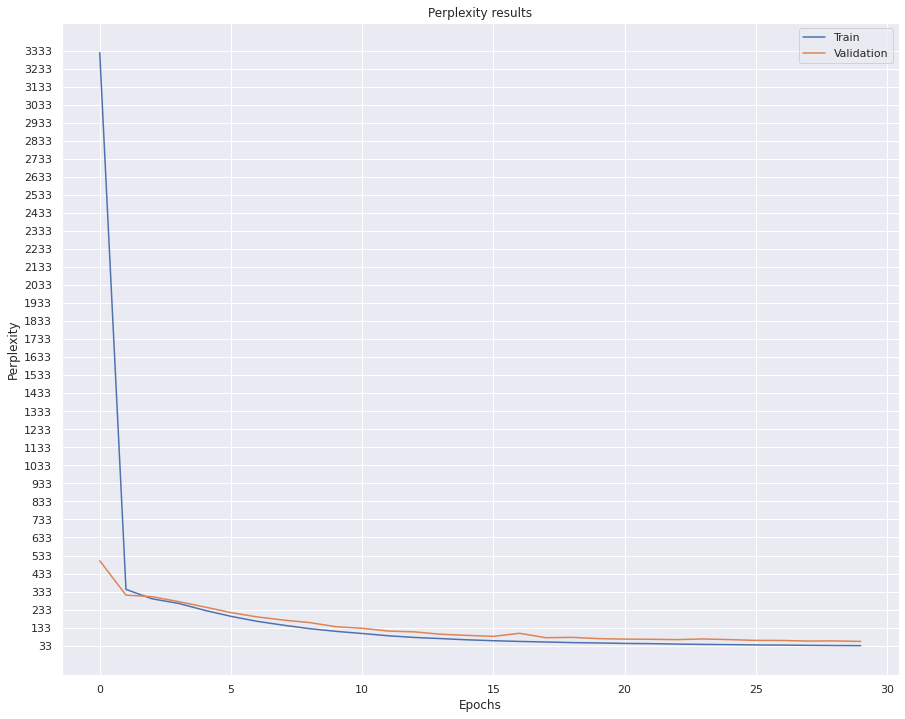

In [59]:
plt.figure(figsize=(15,12))
plt.title('Perplexity results')
plt.plot(df['train_perplexity'])
plt.plot(df['val_perplexity'])
plt.xlabel('Epochs')
plt.ylabel('Perplexity')
plt.yticks(np.arange(min(df['train_perplexity']), max(df['train_perplexity'])+100,100))
plt.legend(['Train', 'Validation']);

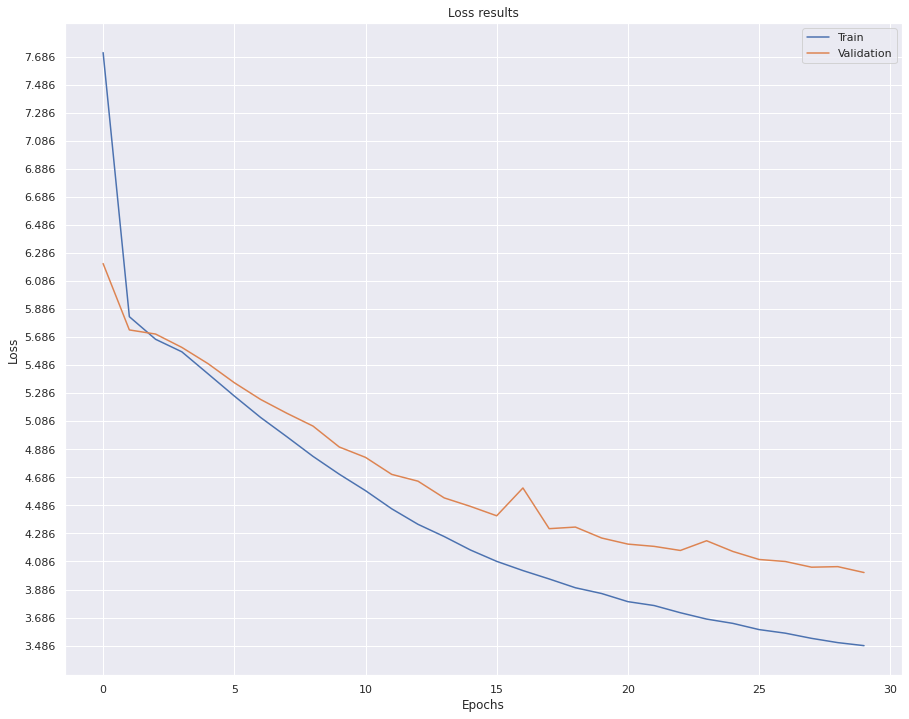

In [60]:
plt.figure(figsize=(15,12))
plt.title('Loss results')
plt.plot(df['train_loss'])
plt.plot(df['val_loss'])
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.yticks(np.arange(min(df['train_loss']),max(df['train_loss']),0.2))
plt.legend(['Train', 'Validation']);

# Testing model

In [61]:
import matplotlib.pyplot as plt
import seaborn as sns

In [62]:
class Decoder:
    def __init__(self, encoder: tf.keras.Model,
                 decoder: tf.keras.Model,
                 start_token: int,
                 end_token: int,
                 max_len: int = None,
                 units:int = 256):
        self.encoder = encoder
        self.decoder = decoder
        self.max_len = max_len if max_len else 100
        self.start_token = start_token
        self.end_token = end_token
        self.units = units

    def decode(self, input):
        pass


class GreedyDecoder(Decoder):
    def __init__(self, encoder: tf.keras.Model,
                 decoder: tf.keras.Model,
                 start_token: int,
                 end_token: int,
                 max_len: int = 10,
                 units:int = 256
                 ):
        super().__init__(encoder,
                         decoder,
                         start_token,
                         end_token,
                         max_len,
                         units
                         )

    def decode(self, input):
        features = self.encoder(np.expand_dims(input, axis=0))
        hidden = np.zeros((1,self.units))
        target_seq = np.zeros((1, 1))
        target_seq[0, 0] = self.start_token
        res = []
        while True:
            # Sample a token
            output, hidden, _ = self.decoder(target_seq,features,hidden)
            sampled_token_index = np.argmax(tf.nn.softmax(output.numpy()))
            if len(res) > self.max_len or sampled_token_index == self.end_token:
                break

            res.append(sampled_token_index)

            target_seq = np.zeros((1, 1))
            target_seq[0, 0] = sampled_token_index

       
        return res


In [63]:
class BeamSearchDecoder(Decoder):
    def __init__(self, encoder: tf.keras.Model,
                 decoder: tf.keras.Model,
                 start_token: int,
                 end_token: int,
                 max_len: int = 10,
                 units:int = 256
                 ):
        super().__init__(encoder,
                         decoder,
                         start_token,
                         end_token,
                         max_len,
                         units
                         )

    def decode(self, input, beam_size=3):
        start = [self.start_token]
        features = self.encoder(np.expand_dims(input,axis=0))

        hidden = np.zeros((1,self.units))
        start_word = [[start, 0.0, hidden]]

        while len(start_word[0][0]) < self.max_len:
            temp = []
            for s in start_word:
                target_seq = np.array([[s[0][-1]]])
                hidden = s[-1]
                output, hidden, _ = self.decoder(target_seq, features, hidden)
                output = np.hstack(output)
                output = tf.nn.softmax(output).numpy()
                word_preds = np.argsort(output)[-beam_size:]

                for w in word_preds:
                    next_cap, prob = s[0][:], s[1]
                    next_cap.append(w)
                    prob += output[w]
                    temp.append([next_cap, prob, hidden])

            start_word = temp
            # Sorting according to the probabilities
            start_word = sorted(start_word, reverse=False, key=lambda l: l[1])
            # Getting the top words
            start_word = start_word[-beam_size:]

        start_word = start_word[-1][0]

        final_caption = []

        for i in start_word:
            if i != self.end_token:
                final_caption.append(i)
            else:
                break
        return final_caption[1:]

In [64]:
def predict(data, decoder, inverse_vocab,
           beam_size=None):
    if beam_size:
        result = decoder.decode(data, beam_size=beam_size)
    else:
        result = decoder.decode(data)
    return ' '.join([inverse_vocab[i] for i in result])

In [65]:
greedy_decoder = GreedyDecoder(conv_encoder, lstm_decoder, vocab[start_token], vocab[end_token],
             max_len=10, units=256)

In [66]:
beam_decoder = BeamSearchDecoder(conv_encoder, lstm_decoder, vocab[start_token], vocab[end_token],
             max_len=10, units=256)

In [67]:
images.shape

(3840, 224, 224, 3)

In [68]:
idx = np.random.choice(range(len(images)))
sample = images[idx]

the man is enjoying the time with pigs


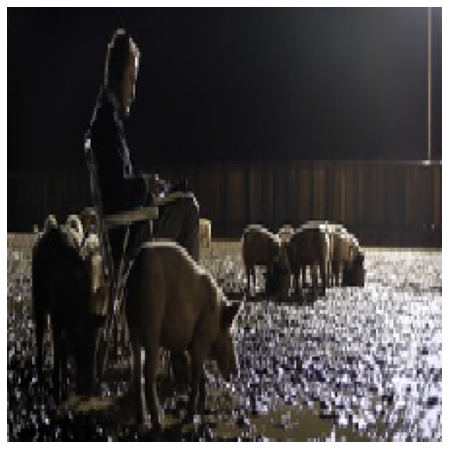

In [69]:
plt.figure(figsize=(8,8))
plt.imshow(sample)
plt.grid([])
plt.axis('off');
print(annotations[idx])

In [70]:
predict(sample, greedy_decoder, inverse_vocab)


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.



'the man looks couple looks couple looks couple looks couple looks'

In [71]:
predict(sample, beam_decoder, inverse_vocab, beam_size=3)

'the man looks happy man looks happy man looks'

In [72]:
predict(sample, beam_decoder, inverse_vocab, beam_size=5)

'the man looks happy man looks happy man looks'

In [73]:
predict(sample, beam_decoder, inverse_vocab, beam_size=7)

'the man looks serious man looks happy man looks'

In [74]:
predict(sample, beam_decoder, inverse_vocab, beam_size=10)

'the man looks serious man looks happy man looks'

# Blue score calculation

In [75]:
from nltk.translate.bleu_score import sentence_bleu


### making predictions on test dataset with beam_size of 5

In [76]:
test_predictions = []
for batch in tqdm(test_images):
    for image in batch:
        result = predict(image, beam_decoder, inverse_vocab, beam_size=5)
        test_predictions.append(result)

100%|██████████| 6/6 [04:57<00:00, 49.51s/it]


In [77]:
test_predictions = [i.split(' ') for i in test_predictions]

In [78]:
reshaped_sequences = test_sequences.reshape(test_sequences.shape[0]*test_sequences.shape[1],-1)

In [79]:
test_sentences = []
for i in reshaped_sequences:
    tmp = []
    for word in i:
        if word!=0 and word!=1 and word!=2:
            tmp.append(inverse_vocab[word])
    test_sentences.append(tmp)

In [80]:
bleu_score = []
for reference, prediction in zip(test_sentences, test_predictions):
    bleu_score.append(sentence_bleu([reference], prediction))
print('Overall bleu score on test data : {}'.format(np.mean(bleu_score)))
df['overall_bleu'] = np.mean(bleu_score)*100

Overall bleu score on test data : 0.0035680503674724376


/home/ec2-user/anaconda3/envs/amazonei_tensorflow2_p36/lib/python3.6/site-packages/nltk/translate/bleu_score.py:523: UserWarning: 
The hypothesis contains 0 counts of 2-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/home/ec2-user/anaconda3/envs/amazonei_tensorflow2_p36/lib/python3.6/site-packages/nltk/translate/bleu_score.py:523: UserWarning: 
The hypothesis contains 0 counts of 3-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/home/ec2-user/anaconda3/envs/amazonei_tensorflow2_p36/lib/python3.6/site-packages/nltk/translate/bleu_score.py:523: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
ho

In [81]:
bleu_score = []
for reference, prediction in zip(test_sentences, test_predictions):
    bleu_score.append(sentence_bleu([reference], prediction, weights=(1,)))
print('Bleu score on test data for n-gram = 1 : {}'.format(np.mean(bleu_score)))
df['n1_bleu'] = np.mean(bleu_score)*100

Bleu score on test data for n-gram = 1 : 0.16853465946086357


In [82]:
bleu_score = []
for reference, prediction in zip(test_sentences, test_predictions):
    bleu_score.append(sentence_bleu([reference], prediction, weights=(0,1)))
print('Bleu score on test data for n-gram = 2 : {}'.format(np.mean(bleu_score)))
df['n2_bleu'] = np.mean(bleu_score)*100

Bleu score on test data for n-gram = 2 : 0.053516911928791044


In [83]:
bleu_score = []
for reference, prediction in zip(test_sentences, test_predictions):
    bleu_score.append(sentence_bleu([reference], prediction, weights=(0,0,1)))
print('Bleu score on test data for n-gram = 3 : {}'.format(np.mean(bleu_score)))
df['n3_bleu'] = np.mean(bleu_score)*100

Bleu score on test data for n-gram = 3 : 0.013967540317059088


In [84]:
bleu_score = []
for reference, prediction in zip(test_sentences, test_predictions):
    bleu_score.append(sentence_bleu([reference], prediction, weights=(0,0,0,1)))
print('Bleu score on test data for n-gram = 4 : {}'.format(np.mean(bleu_score)))
df['n4_bleu'] = np.mean(bleu_score)*100

Bleu score on test data for n-gram = 4 : 0.0026041666666666665


In [85]:
bleu_score = []
for reference, prediction in zip(test_sentences, test_predictions):
    bleu_score.append(sentence_bleu([reference], prediction, weights=(0.25,0.25,0.25,0.25)))
print('Acuumulated bleu score on test data for n-gram = 4 : {}'.format(np.mean(bleu_score)))
df['acc_bleu'] = np.mean(bleu_score)*100

Acuumulated bleu score on test data for n-gram = 4 : 0.0035680503674724376


In [86]:
df.head()

,train_perplexity,val_perplexity,train_loss,val_loss,overall_bleu,n1_bleu,n2_bleu,n3_bleu,n4_bleu,acc_bleu
0,3322.468750,504.005859,7.713783,6.209583,0.356805,16.853466,5.351691,1.396754,0.260417,0.356805
1,345.038483,313.383514,5.830975,5.736628,0.356805,16.853466,5.351691,1.396754,0.260417,0.356805
2,292.636139,304.535187,5.669844,5.707201,0.356805,16.853466,5.351691,1.396754,0.260417,0.356805
3,267.734589,277.494446,5.580690,5.612169,0.356805,16.853466,5.351691,1.396754,0.260417,0.356805
4,228.991028,247.610153,5.423478,5.496045,0.356805,16.853466,5.351691,1.396754,0.260417,0.356805


In [87]:
df.to_csv('{}_logs.csv'.format(model_name),index=False)

In [88]:
conv_encoder.save_weights('{}_encoder.h5'.format(model_name))

In [89]:
lstm_decoder.save_weights('{}_decoder.h5'.format(model_name))

# Predictions on own data

In [90]:
img = np.array(im.load_img('hospital-birth.jpg', target_size=(224,224)))/255

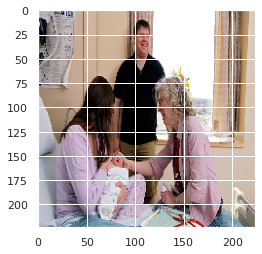

In [91]:
plt.imshow(img)

In [92]:
predict(img, greedy_decoder, inverse_vocab)

'the man is happy man is happy man is happy man'

In [93]:
predict(img, beam_decoder, inverse_vocab, beam_size=3)

'the man is happy man is happy man is'

In [94]:
predict(img, beam_decoder, inverse_vocab, beam_size=5)

'the man is happy man is happy man is'

In [95]:
predict(img, beam_decoder, inverse_vocab, beam_size=7)

'the man is happy man is happy man is'

In [96]:
predict(img, beam_decoder, inverse_vocab, beam_size=10)

'the man is happy man is happy man is'